# Image Classifier with Keras

This is an alpaca-llama classifier built with Keras. The dataset comprises of just over 100 images per class. The alpaca images were scraped from Bing while the llama images were taken from ImageNet. Already, there is a potential problem with varying interclass data quality and the dataset size. To mitigate the data quality issue, the images scraped from Bing were manually reviewed to ensure that they were correctly labelled and were had good resolution.

In [2]:
from google.colab import files
files.upload()

Saving alpaca_example.jpeg to alpaca_example.jpeg
Saving dataset.zip to dataset.zip
Saving Llama_example.jpg to Llama_example.jpg


In [0]:
!unzip -uq dataset.zip

In [0]:
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
base_dir = os.path.join(os.getcwd(), 'images')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [16]:
nb_train_samples = len(os.listdir(os.path.join(train_dir, 'alpaca'))) * 2
nb_validation_samples = len(os.listdir(os.path.join(validation_dir, 'alpaca'))) * 2
nb_test_samples = len(os.listdir(os.path.join(test_dir, 'alpaca'))) * 2
print(nb_train_samples)
print(nb_validation_samples)
print(nb_test_samples)

142
48
48


We configure the data augmentation operations to be done during training, as well as initialize generators of augmented image batches. Due to having a small dataset, the batch sizes was decided to be the entire train/dev/test set.

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=nb_train_samples,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=nb_validation_samples,
    class_mode='binary')

Found 142 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


Here we visualize some of the randomly augmented images from our train set generator.

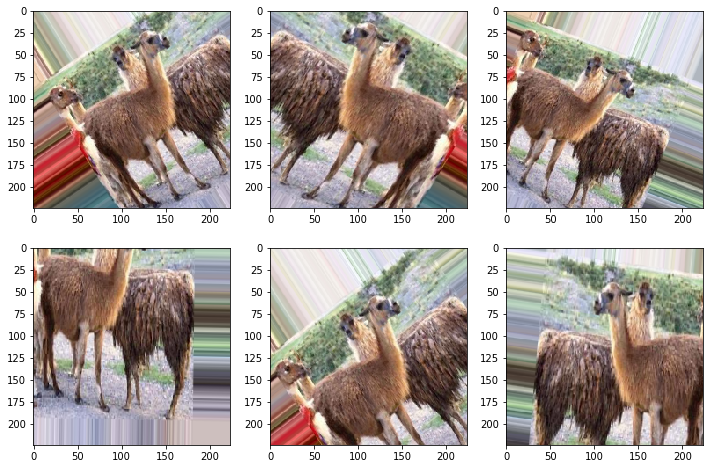

In [18]:
train_llama_dir = os.path.join(train_dir, 'llama')
img_path = os.path.join(train_llama_dir, os.listdir(train_llama_dir)[1])
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
plt.figure(figsize=(12, 8))
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(2, 3, i+1)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break
plt.show()

## Training

We will use the bottleneck features from a VGG16 architecture pre-trained on ImageNet.

In [19]:
epochs = 50
nb_train_samples = len(train_generator)
nb_validation_samples = len(validation_generator)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=1,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
58892288/58889256 [==============================] - 3s 0us/step
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
1/1 [==============================] - 20s 20s/step - loss: 0.8041 - acc: 0.5000 - val_loss: 7.7098 - val_acc: 0.5000
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 7.5308 - acc: 0.5000 - val_loss: 2.6778 - val_acc: 0.5000
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 2.6060 - acc: 0.5141 - val_loss: 1.9668 - val_acc: 0.5000
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 2.0307 - acc: 0.5000 - val_loss: 1.0068 - val_acc: 0.5000
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 1.2206 - acc: 0.5986 - val_loss: 1.5035 - val_acc: 0.5000
Epoch 6/50
1/1 [==============================] - 2s 2s/step - loss: 1.5449 - acc: 0.5

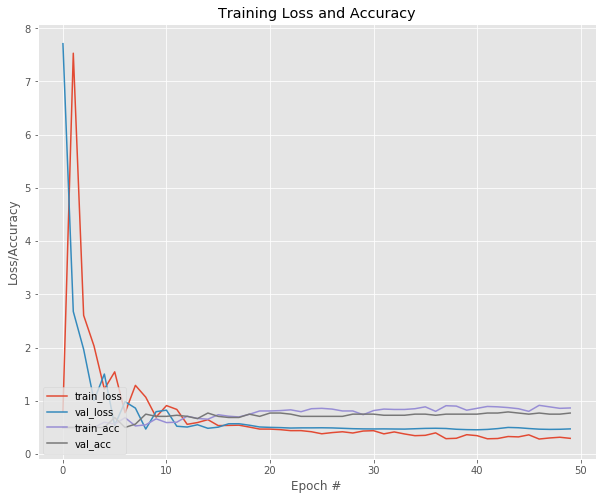

In [20]:
def plot_training(H, N):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure(figsize=(10, 8))
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")

plot_training(history, epochs)

## Testing

Our model achieved a test accuracy of 81%.

In [21]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=nb_test_samples,
    class_mode='binary')

nb_test_samples = len(test_generator)

score = model.evaluate_generator(
    test_generator,
    steps=1)

print("Loss: ", score[0], "Accuracy: ", score[1])

Found 48 images belonging to 2 classes.
Loss:  0.5036516785621643 Accuracy:  0.8125


In [0]:
import cv2
import imutils

def predict_image(img_path):
    image = cv2.imread(img_path)
    output = image.copy()
    output = imutils.resize(output, width=400)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    image = image.astype("float32")
    image /= 255
    pred = model.predict(np.expand_dims(image, axis=0))[0][0]

    label = 'Llama' if pred > 0.5 else 'Alpaca'
    proba = pred if pred > 0.5 else 1 - pred
    text = "{}: {:.2f}%".format(label, proba * 100)
    cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    plt.style.use('default')
    plt.imshow(output);

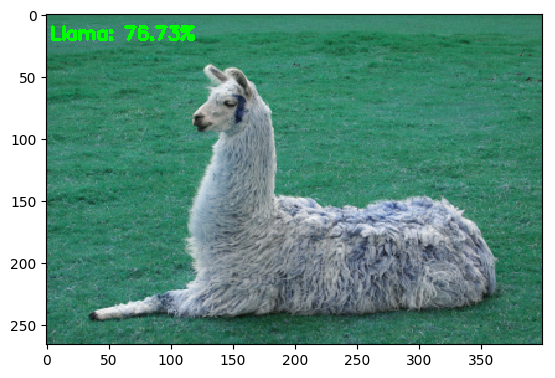

In [23]:
llama_image = os.path.join(os.getcwd(), 'Llama_example.jpg')
predict_image(llama_image)

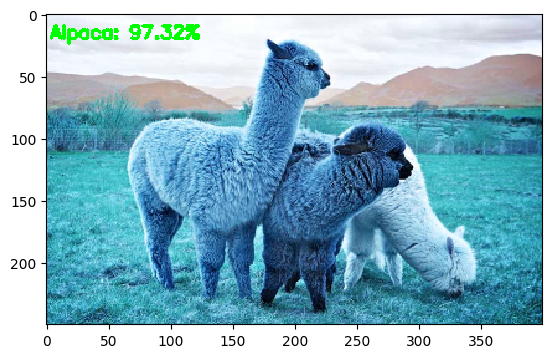

In [24]:
alpaca_image = os.path.join(os.getcwd(), 'alpaca_example.jpeg')
predict_image(alpaca_image)

## Conclusion

Several improvements could have been made. A larger dataset could have been, particularly so that we could have more samples for our validation and test sets for more reliable metrics. Furthermore, we could have fine-tuned our model by unfreezing some of the last few layers of our pre-trained model (all the layers were frozen so their parameters would not update during training).